# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid, save_image

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

from art.estimators.classification import PyTorchClassifier
from art.attacks.poisoning import BullseyePolytopeAttackPyTorch

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

# Load Data

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])

In [3]:
train_data = torchvision.datasets.MNIST(root='./mnist', train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST(root='./mnist', train=False, download=True, transform=transform)

In [4]:
batch_size = 16
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Visualization

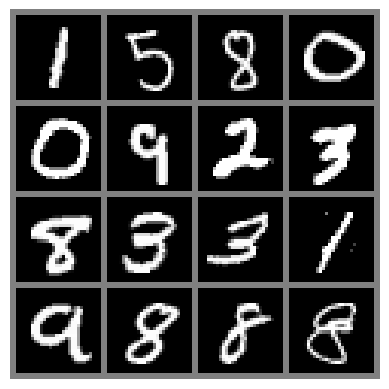

In [5]:
data_iter = iter(train_dataloader)
images, _ = next(data_iter)

def imshow(img):
    npimg = img.numpy()
    plt.imshow(npimg[0], cmap='gray')
    plt.axis('off')
    plt.show()

imshow(make_grid(images, nrow=4))

# Model

In [6]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=1)
        self.fc = nn.Linear(3200, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [7]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=4, stride=2),
    nn.Conv2d(16, 32, kernel_size=4, stride=1),
    nn.Flatten(),
    nn.Linear(3200, 10),
    nn.ReLU()
).to(device)

# Train

In [8]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
loss_fn = nn.CrossEntropyLoss()

In [10]:
def train_model(model, optimizer, loss_fn, train_dataloader, batch_size=32, epochs=5):
    for epoch in range(epochs):
        total_loss = 0.0
        
        for batch_idx, (images, labels) in enumerate(train_dataloader):

            images = images.to(device)
            labels = labels.to(device)
    
            optimizer.zero_grad()
    
            outputs = model(images)
    
            loss = loss_fn(outputs, labels)
            loss.backward()
    
            optimizer.step()
    
            total_loss += loss.item()

            if batch_idx % 60000 == 0:
                print(f"Epoch {epoch+1}, Loss: {total_loss / 60000:.4f}")
                total_loss = 0.0

    return model

In [11]:
model = train_model(model, optimizer, loss_fn, train_dataloader)

Epoch 1, Loss: 0.0000
Epoch 2, Loss: 0.0000
Epoch 3, Loss: 0.0000
Epoch 4, Loss: 0.0000
Epoch 5, Loss: 0.0000


# Test

In [12]:
classes = train_data.classes
correct_pred = {class_name: 0 for class_name in classes}
total_pred = {class_name: 0 for class_name in classes}

with torch.no_grad():
    model.eval()

    for data in test_dataloader:
        inputs = data[0].to(device)
        labels = data[1].to(device)

        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for class_name, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[class_name]
    print(f'Accuracy for class: {class_name} is {accuracy:.2f} %')

total_accuracy = 100 * float(np.sum(list(correct_pred.values())) / np.sum(list(total_pred.values())))
print(f'Total Accuracy: {total_accuracy:.2f} %')

Accuracy for class: 0 - zero is 96.84 %
Accuracy for class: 1 - one is 98.68 %
Accuracy for class: 2 - two is 89.63 %
Accuracy for class: 3 - three is 85.15 %
Accuracy for class: 4 - four is 92.87 %
Accuracy for class: 5 - five is 91.26 %
Accuracy for class: 6 - six is 93.01 %
Accuracy for class: 7 - seven is 93.68 %
Accuracy for class: 8 - eight is 0.00 %
Accuracy for class: 9 - nine is 86.92 %
Total Accuracy: 83.11 %


# Bullseye Polytope Attack

In [44]:
pt_model = PyTorchClassifier(
    model=model,
    loss=nn.CrossEntropyLoss(),
    input_shape=(1, 28, 28),
    clip_values=(0, 1),
    preprocessing=(0.5, 0.5),
    nb_classes=10,
    device_type="cpu"
)

In [45]:
target = images[0].unsqueeze(0)

In [46]:
attack = BullseyePolytopeAttackPyTorch(pt_model, target.numpy(), 3)

In [47]:
poison, p_labels = attack.poison(images.numpy() / 2 + 0.5, labels.numpy())

  0%|          | 0/4000 [00:00<?, ?it/s]

# Results

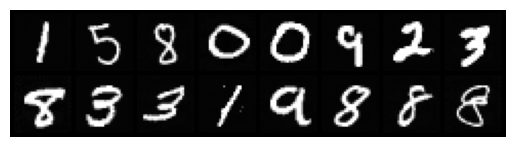

In [56]:
imshow(make_grid(torch.from_numpy(poison)))